# Introduction

## Standard imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import time
np.random.seed(int(time.time()))

## Specific imports

In [76]:
#import matplotlib as mpl
#from noise_analysis import noise_color
#from scipy import stats
from noise_properties_plotting import noise_cmap_ww , noise_lim#, PiecewiseNormalize, \
#    PlotTimeseriesComparison, PlotNoiseColorComparison
from generate_timeseries import Timeseries, is_stable
#from noise_parameters import NOISE, MODEL
from math import ceil

## Settings figures

In [2]:
from elife_settings import set_elife_settings, ELIFE

set_elife_settings()

In [66]:
def plot_overview(file, num=0):
    x = ['noisecolor_mean', 'noisecolor_std', 'KL', 'means', 'stds'] #, 'NCT']
    labels = ['noise mean', 'noise std', r'log$_{10}$(KL)', 'mean', 'std'] #, r'log$_{10}(p_{NCT})$']
    
    if num == 0:
        data = [ pd.read_csv(file % s, index_col=0) for s in x]
    else:
        data = [ pd.DataFrame( np.nanmean(
                [pd.read_csv(file % (s, iii), index_col=0).values 
                     for iii in num], axis=0),
                          columns = pd.read_csv(file % (s, num[0]), index_col=0).columns,
                        index = pd.read_csv(file % (s, num[0]), index_col=0).index) for s in x]

    gs = gridspec.GridSpec(3,9,width_ratios=[8,1,4,8,1,4,8,1,0], hspace=0.7, wspace=0.3)

    fig = plt.figure(figsize = (15,7))

    for i, df in enumerate(data):
        ax = fig.add_subplot(gs[3*i])
        ax_clb = fig.add_subplot(gs[3*i+1])
        ax.set_facecolor('lightgrey')

        if x[i] == 'noisecolor_mean':
            mat = ax.matshow(df.T, origin='lower', cmap=noise_cmap_ww, vmin=noise_lim[0], vmax=noise_lim[1], aspect='auto')
        elif x[i] == 'KL':
            mat = ax.matshow(np.log10(df.T), origin='lower', cmap='Blues', aspect='auto', vmin=-1, vmax=3)
        elif x[i] == 'NCT':
            vmin = -5; vmax = 0 # pvalue is max 1 = 1e0
            norm = PiecewiseNormalize([vmin, np.log10(0.05), vmax], [0, 0.5, 1])
            mat = ax.matshow(np.log10(df.T), origin='lower', norm=norm, cmap='seismic_r', aspect='auto', vmin=vmin, vmax=vmax)
        else:
            mat = ax.matshow(df.T, origin='lower', aspect='auto')
        ax.set_xticks(range(0, df.shape[0], 2))
        ax.set_xticklabels(['%.2f' % i for i in df.index][::2])
        ax.set_yticks(range(0, df.shape[1], 2))
        ax.set_yticklabels(['%.1f' % i for i in df.columns.astype(float)][::2])
        ax.set_xlabel('Interaction')
        ax.set_ylabel('Noise')

        ax.set_title(labels[i], y=1.2)

        clb = fig.colorbar(mat, cax=ax_clb)
        
        if x[i] == 'NCT':
            ax_clb.set_title(r'log$_{10}$($p_{NCT}$)')
            ax_clb2 = ax_clb.twinx()
            ax_clb2.yaxis.set_ticks_position('right')
            ax_clb.yaxis.set_ticks_position('left')
            ax_clb2.yaxis.set_ticks([1+(vmin + np.log10(0.05))/(vmax - vmin)/2,
                                    1+(vmax + np.log10(0.05))/(vmax - vmin)/2])
            ax_clb2.set_ylim([0,1])
            ax_clb2.yaxis.set_ticklabels(['niche','neutral'])

In [73]:
class PlotOverview:
    def __init__(self, files, composition=['noisecolor_mean', 'noisecolor_std', 'KL', 'means', 'stds', 'NCT']):
        if isinstance(files, str):
            files = [files]

        labels = {'noisecolor_mean': 'noise mean', 'noisecolor_std' : 'noise std', 'KL': r'log$_{10}$(KL)',
                 'means': 'mean', 'stds': 'std', 'NCT': r'log$_{10}(p_{NCT})$'}

        self.data = {}

        for c in composition:
            median_vals = np.nanmedian([pd.read_csv(file % c, index_col=0).values for file in files], axis = 0)

            self.data[c] = pd.DataFrame(median_vals.T, 
                                        columns = pd.read_csv(files[0] % c, index_col=0).index,
                                        index = pd.read_csv(files[0] % c, index_col=0).columns)

        gs = gridspec.GridSpec(ceil(len(composition)/3), 9, width_ratios=[8, 1, 4, 8, 1, 4, 8, 1, 0],
                               hspace=0.7, wspace=0.3)
        gs_tot = gridspec.GridSpec(1,1, left=0.05, right=0.95, top=0.95, bottom=0.05)
        
        self.fig = plt.figure(figsize=(10, 2*ceil(len(composition)/3)))
        
        ax = self.fig.add_subplot(gs_tot[:], frameon=False)
        ax.tick_params(axis='both', left=False, labelleft=False, bottom=False, labelbottom=False)
        ax.set_xlabel('Interaction')
        ax.set_ylabel('Noise')
        
        for i, c in enumerate(composition):
            ax = self.fig.add_subplot(gs[3*i])
            ax_cbar = self.fig.add_subplot(gs[3*i+1])
            
            ax.set_title(labels[c], y=1.2)

            self.plot_matrix(c, ax, ax_cbar)
        
    def plot_matrix(self, c, ax, ax_cbar):
        ax.set_facecolor('lightgrey')
        if c == 'noisecolor_mean':
            mat = ax.matshow(self.data[c], origin='lower', cmap=noise_cmap_ww,
                             vmin=noise_lim[0], vmax=noise_lim[1], aspect='auto')
        elif c == 'KL':
            mat = ax.matshow(np.log10(self.data[c]), origin='lower',
                             cmap='Blues', aspect='auto', vmin=-1, vmax=3)
        elif c == 'NCT':
            vmin = -5; vmax = 0  # pvalue is max 1 = 1e0
            norm = PiecewiseNormalize(
                [vmin, np.log10(0.05), vmax], [0, 0.5, 1])
            mat = ax.matshow(np.log10(self.data[c]), origin='lower', norm=norm,
                             cmap='seismic_r', aspect='auto', vmin=vmin, vmax=vmax)
        else:
            mat = ax.matshow(self.data[c], origin='lower', aspect='auto')
        ax.set_xticks(range(0, self.data[c].shape[1], 2))
        ax.set_xticklabels(['%.2f' % i for i in self.data[c].columns.astype(float)][::2])
        ax.set_yticks(range(0, self.data[c].shape[0], 2))
        ax.set_yticklabels(['%.1f' % i for i in self.data[c].index.astype(float)][::2])
        
        clb = self.fig.colorbar(mat, cax=ax_cbar)

        if c == 'NCT':
            ax_cbar.set_title(r'log$_{10}$($p_{NCT}$)')
            ax_cbar2 = ax_cbar.twinx()
            ax_cbar2.yaxis.set_ticks_position('right')
            ax_cbar.yaxis.set_ticks_position('left')
            ax_cbar2.yaxis.set_ticks([1+(vmin + np.log10(0.05))/(vmax - vmin)/2,
                                    1+(vmax + np.log10(0.05))/(vmax - vmin)/2])
            ax_cbar2.set_ylim([0,1])
            ax_cbar2.yaxis.set_ticklabels(['niche','neutral'])

# Fisher Mehta methods

Generate timeseries

In [18]:
new = False

S = 50

lamda = 0.01
mu = 1.0 # mean interaction strength 
sigmas = np.arange(0,1.1,0.2) # spread interaction strength
omegas = np.arange(0.1,1.1,0.1) # noise

Nsteps = 5e5
tskip = 99
dt = 0.005
T = Nsteps*dt 

if new:
    for sigma in sigmas:
        for omega in omegas:
            f = "KullbackLeibler/Mehta2B/LV-%.2f-%.2f.csv" % (sigma, omega)
                     
            # interaction
            if sigma == 0:
                intmat = np.zeros([S,S])
            else:
                intmat = - np.random.gamma(1/S*(mu/sigma)**2, sigma**2/mu, [S,S])
                #intmat = - np.random.gamma(mu/S, sigma**2/S, [S,S])
            np.fill_diagonal(intmat, -1)

            # no immigration
            mu = np.full([S, 1], lamda)

            # carrying capacity
            K = np.ones([S,1])
            
            # random initialization
            initcond = np.random.lognormal(0, omega, [S,1])
            
            var = intmat, mu, K, initcond
           
            if os.path.exists(f):
                os.remove(f)
                #print("already exists")
            #else:
            Timeseries(var, noise=omega, model = MODEL.GLV,
                                noise_implementation = NOISE.SQRT_MILSTEIN, #NOISE.LANGEVIN_LINEAR, 
                                 dt=dt, T=T, tskip = tskip).timeseries
            

Calculate the Kullback Leibler divergence. Read the noise colors of the timeseries. Also save the mean abundances.

In [4]:
if False:
    sigmas = np.arange(0,1.1,0.2) # mean interaction strength
    omegas = np.arange(0.1,1.1,0.1) # noise
    
    means = np.zeros((len(sigmas), len(omegas)))
    stds = np.zeros((len(sigmas), len(omegas)))
    KL = np.zeros((len(sigmas), len(omegas)))
    mean_color = np.zeros((len(sigmas), len(omegas)))
    std_color = np.zeros((len(sigmas), len(omegas)))
    
    for i, sigma in enumerate(sigmas):
        print(sigma)
        for j, omega in enumerate(omegas):
            f = "KullbackLeibler/Mehta2B/LV-%.2f-%.2f.csv" % (sigma, omega)
            
            ts = pd.read_csv(f, index_col=0, na_values='NAN')
            
            if not ts.isnull().values.any(): # no NAN values
                means[i,j] = np.mean(ts.values)
                stds[i,j] = np.std(ts.values)
                
                KL[i,j] = KullbackLeibler(ts)
                
                ns = noise_slope(ts)['slope_linear'].values
                
                mean_color[i,j] = np.mean(ns)
                std_color[i,j] = np.std(ns)
    
    for array, name in zip([means, stds, KL, mean_color, std_color],
                            ['means', 'stds', 'KL', 'noisecolor_mean', 'noisecolor_std']):
        array = pd.DataFrame(array, index=sigmas, columns=omegas)
        array.to_csv('KullbackLeibler/Mehta2B/%s-2.csv' % name)

Plot the Kullback Leibler divergences

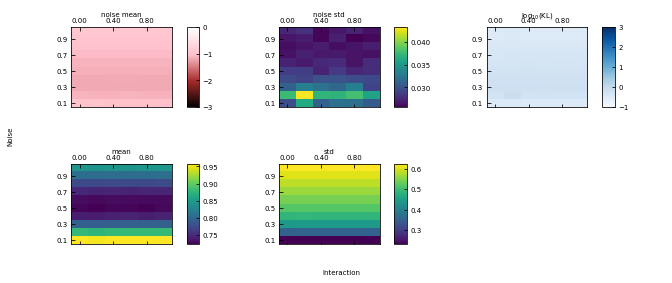

In [74]:
folder = 'results/Mehta/'
PlotOverview([folder + 'Mehta-%s' + '-%d.csv' % i for i in range(20)], 
    composition=['noisecolor_mean', 'noisecolor_std', 'KL', 'means', 'stds'])
plt.show()

# Our methods

Now using our method of generating timeseries (linear multiplicative noise and fixing the steady state). 

In [77]:
new = False

S = 50

mean_abundance = 10.0; ma = '10'

sigmas = np.arange(0,0.22,0.03) # mean interaction strength
omegas = np.append([0.01], np.arange(0.2,1.1,0.2)) # noise

Nsteps = 5e5
tskip = 99
dt = 0.005
T = Nsteps*dt 
    
if new:
    for sigma in sigmas:
        for omega in omegas:
            f = "results/neutrality_Langevin_linear_noise/LV-%s-%.2f-%.2f.csv" % (ma, sigma, omega)
            
            steadystate = mean_abundance*np.ones([S,1])
            initcond = np.copy(steadystate)
            
            stable = False
            
            while not stable:
                # interaction
                if sigma == 0:
                    intmat = np.zeros([S,S])
                else:
                    intmat = np.random.normal(0, sigma, [S,S])
                np.fill_diagonal(intmat, -1)

                # no immigration
                mu = np.zeros([S, 1])

                # growthrates determined by the steady state
                K = - intmat.dot(initcond).reshape([S,1])
                
                stable = is_stable(intmat, steadystate, K)

            var = intmat, mu, K, initcond
           
            if os.path.exists(f):
                print("already exists")
            else:
                run_timeseries_noise(var, noise=omega, f=f, model = MODEL.GLV,
                                noise_implementation = NOISE.LANGEVIN_LINEAR,
                                 dt=dt, T=T, tskip = tskip)

Calculate the Kullback Leibler divergence. Read the noise colors of the timeseries. Also save the mean abundances.

0.0
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.03
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.06
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.09
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.12
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.15
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.18
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.21
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.0
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.03
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.06
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.09
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.12
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.15
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.18
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.21
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.0
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.03
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.06
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.09
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.12
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.15
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.18
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.21
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.0
0.01
0.05
0.1
0.2
0.4
0.6
0.8
1.0
0.03
0.01
0.05
0.1
0.2
0.4
0.

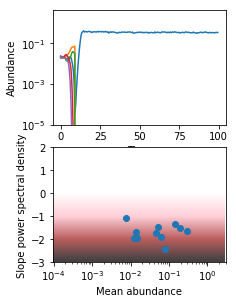

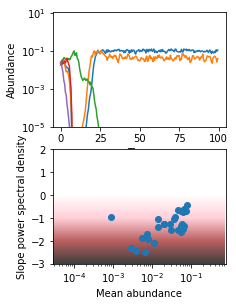

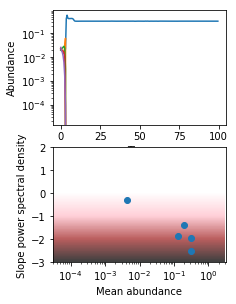

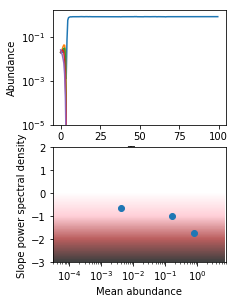

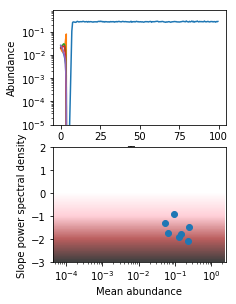

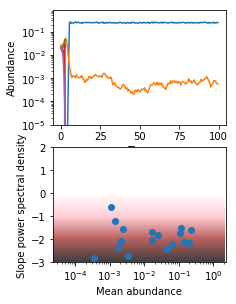

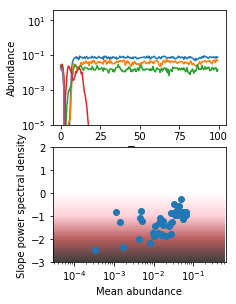

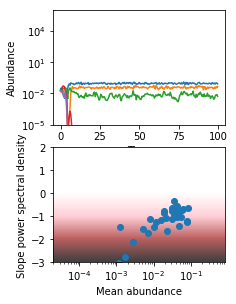

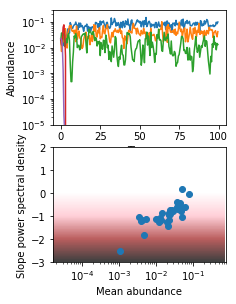

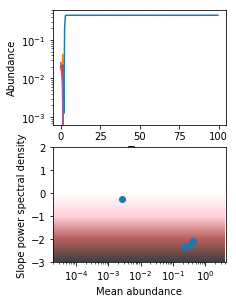

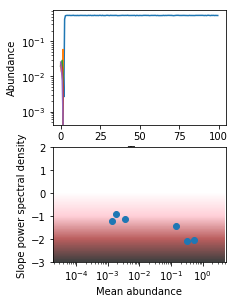

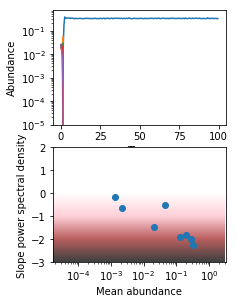

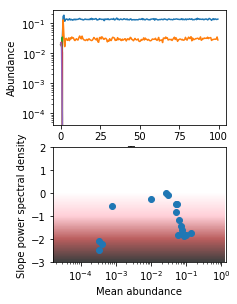

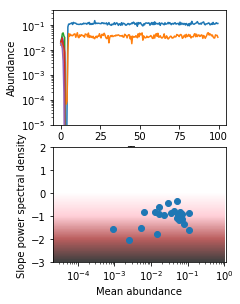

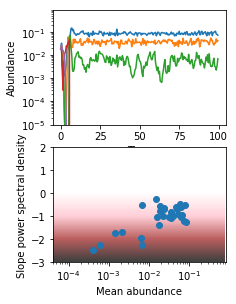

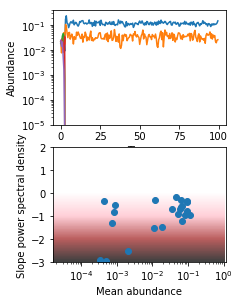

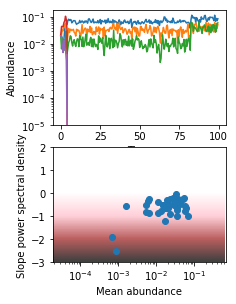

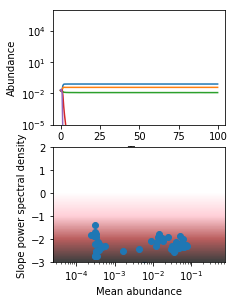

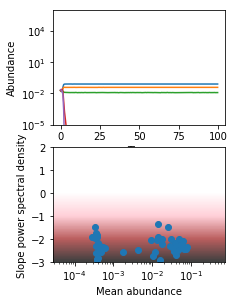

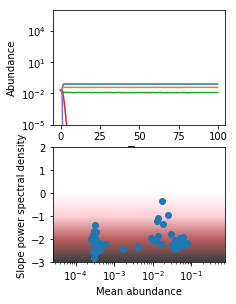

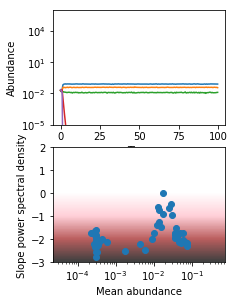

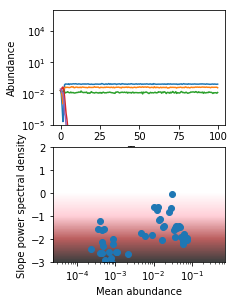

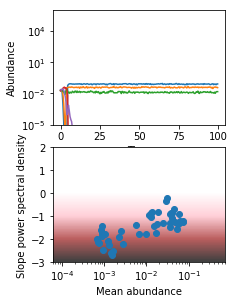

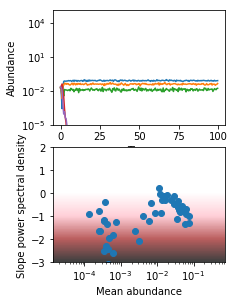

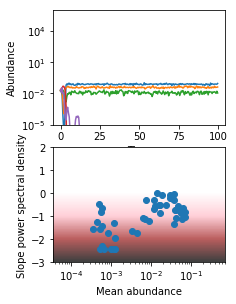

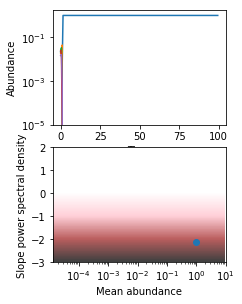

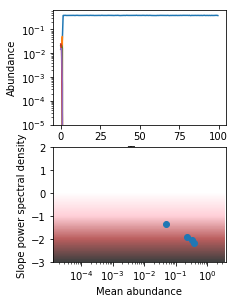

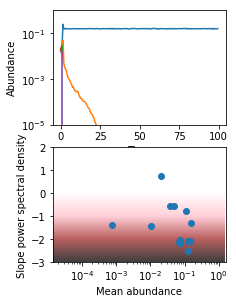

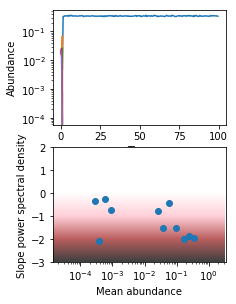

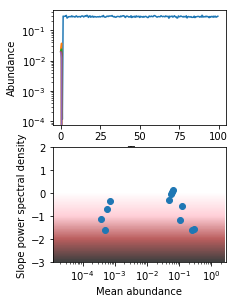

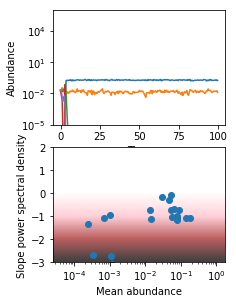

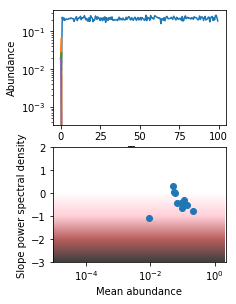

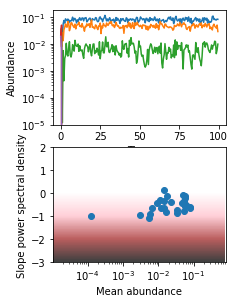

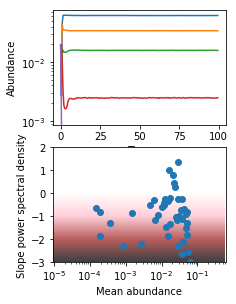

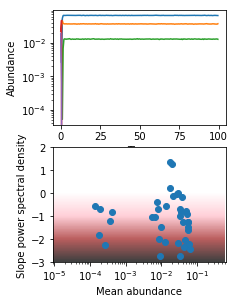

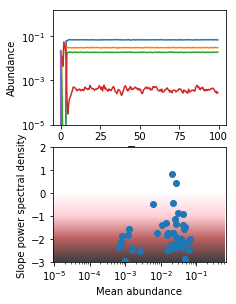

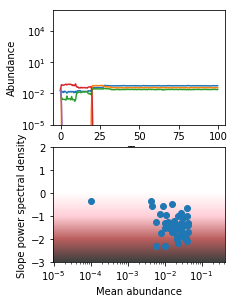

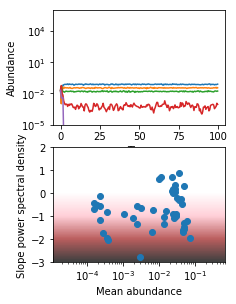

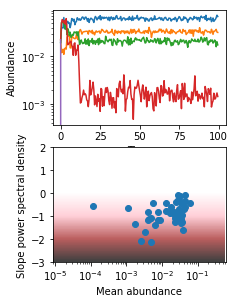

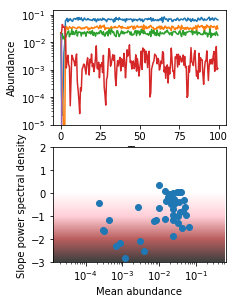

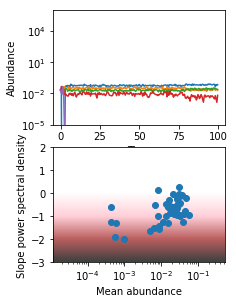

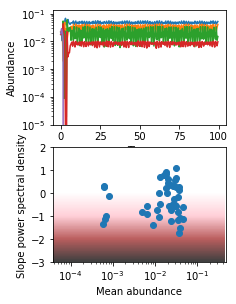

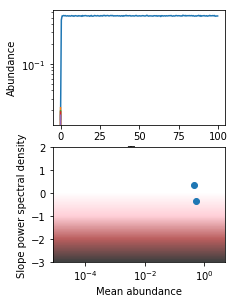

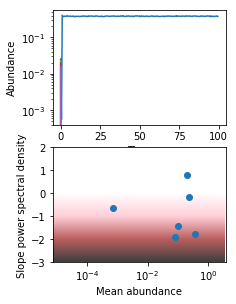

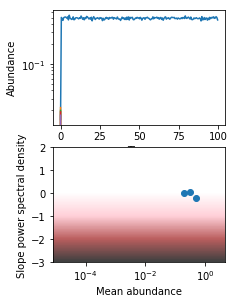

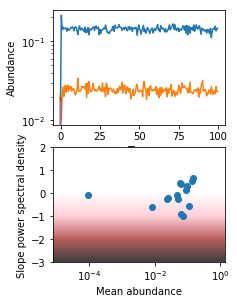

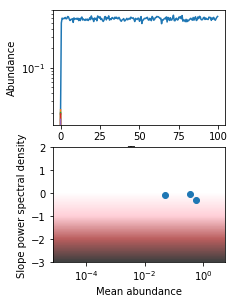

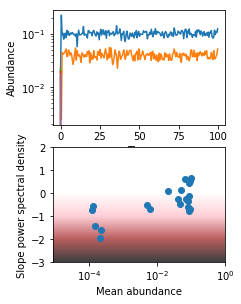

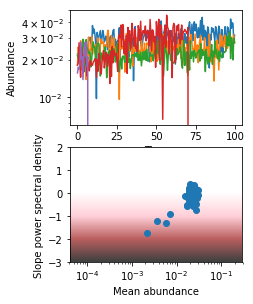

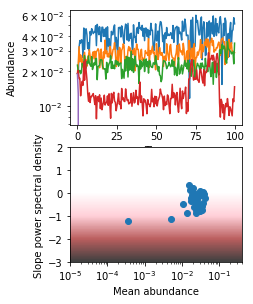

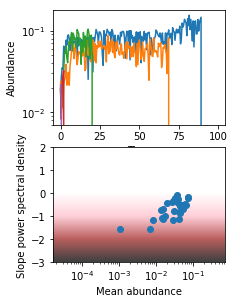

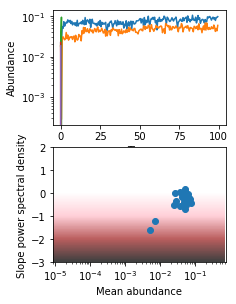

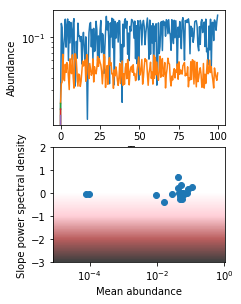

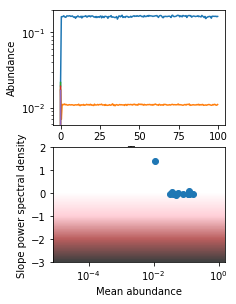

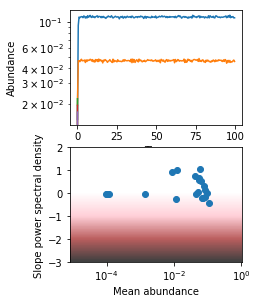

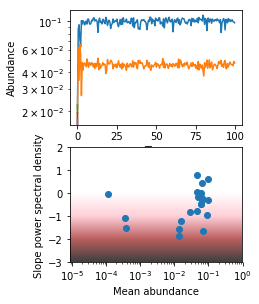

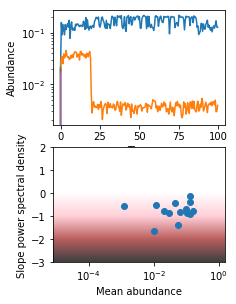

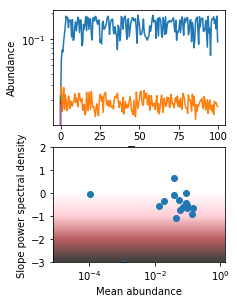

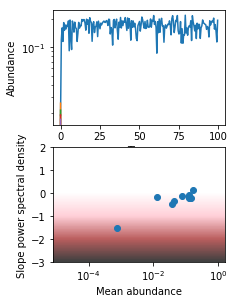

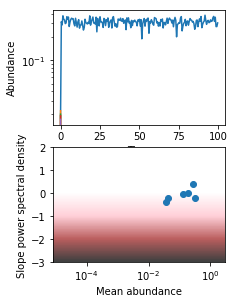

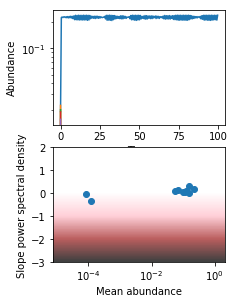

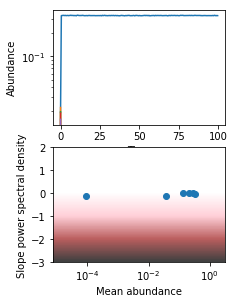

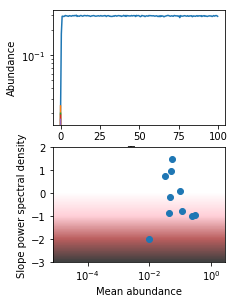

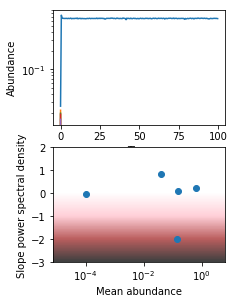

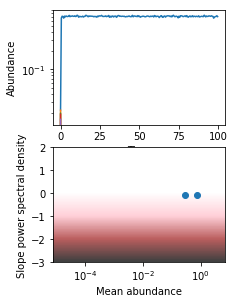

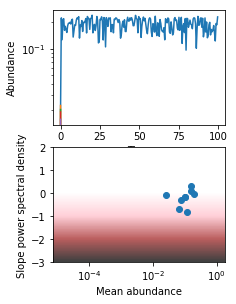

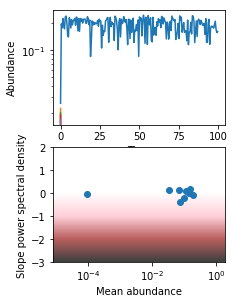

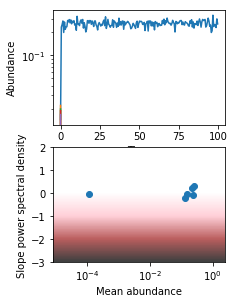

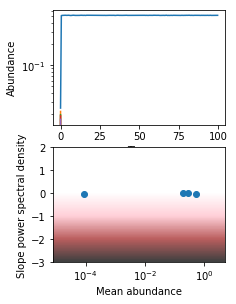

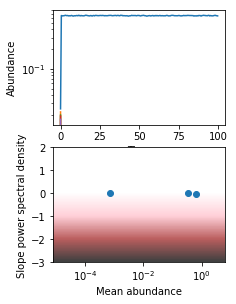

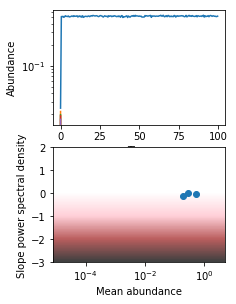

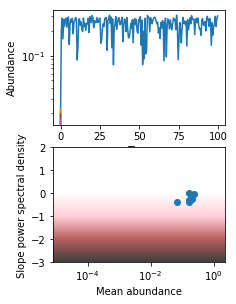

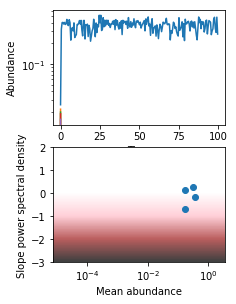

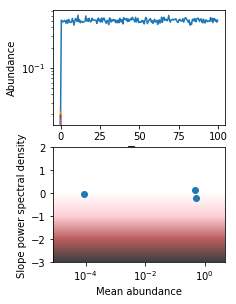

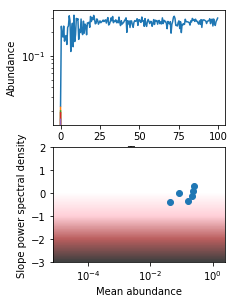

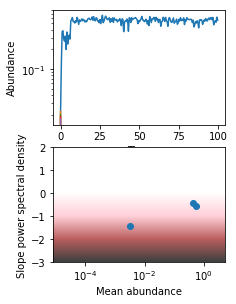

In [53]:
if False:
    for ma in ['0.01', '0.0316', '0.1', '0.178', '0.562', '1', '3.16', '5.62', '10', '31.6','100']:
        S = 50

        #ma = '5.62'

        sigmas = np.arange(0,0.22,0.03) # mean interaction strength 0.03
        omegas = np.append([0.01, 0.05,0.1], np.arange(0.2,1.1,0.2)) # noise 0.2

        means = np.zeros((len(sigmas), len(omegas)))
        stds = np.zeros((len(sigmas), len(omegas)))
        KL = np.zeros((len(sigmas), len(omegas)))
        NCT = np.zeros((len(sigmas), len(omegas)))
        mean_color = np.zeros((len(sigmas), len(omegas)))
        std_color = np.zeros((len(sigmas), len(omegas)))

        for i, sigma in enumerate(sigmas):
            print(sigma)
            for j, omega in enumerate(omegas):
                print(omega)
                params = {}

                steadystate = np.repeat(float(ma), S).reshape([S,1])  
                #experimental_abundance[:S].reshape([S,1]) # np.random.uniform(0,300,[S,1]) #experimental_abundance[:S].reshape([S,1]) # 10**np.random.uniform(0,3,[S,1])
                #steadystate = abs(steadystate)

                params['initial_condition'] = steadystate * np.random.normal(1,0.1, steadystate.shape)

                # interaction
                if sigma == 0:
                    intmat = np.zeros([S,S])
                else:
                    intmat = np.random.normal(0, sigma, [S,S])
                np.fill_diagonal(intmat, -1.2)
                params['interaction_matrix'] = intmat

                # no immigration
                params['immigration_rate'] = np.zeros([S, 1])

                # growthrates determined by the steady state
                params['growthrate'] = - intmat.dot(steadystate).reshape([S,1])

                params['noise'] = omega

                ts = Timeseries(params, model = MODEL.GLV,
                                    noise_implementation = NOISE.LANGEVIN_LINEAR,
                                     dt=0.01, T=100, tskip = 49).timeseries

                if ts.isnull().values.sum().sum() == 0 and np.all(ts.drop('time', axis=1).sum(axis=1) > 0): # no NAN values and not all species die
                    means[i,j] = np.mean(ts.values)
                    stds[i,j] = np.std(ts.values)

                    KL[i,j] = KullbackLeibler(ts)
                    norm_ts = ts.values[:, 1:]
                    norm_ts /= norm_ts.sum(axis=1, keepdims=True)
                    NCT[i,j] = neutral_covariance_test(norm_ts, ntests=500, method = 'Kolmogorov', seed=56)

                    ns = noise_slope(ts)['slope_linear'].values

                    mean_color[i,j] = np.mean(ns)
                    std_color[i,j] = np.std(ns)

                    if np.isnan(mean_color[i,j]) == True:
                        plot_timeseries_comparison([ts], composition=['ts', 'nc'])

        means = pd.DataFrame(means, index=sigmas, columns=omegas)
        stds = pd.DataFrame(stds, index=sigmas, columns=omegas)
        KL = pd.DataFrame(KL, index=sigmas, columns=omegas)
        NCT = pd.DataFrame(NCT, index=sigmas, columns=omegas)
        mean_color = pd.DataFrame(mean_color, index=sigmas, columns=omegas)
        std_color = pd.DataFrame(std_color, index=sigmas, columns=omegas)
        
        folder = 'results/Langevinselfint1.2/'
        
        means.to_csv(folder + 'means_%s.csv' % ma)
        stds.to_csv(folder + 'stds_%s.csv' % ma)
        KL.to_csv(folder + 'KL_%s.csv' % ma)
        NCT.to_csv(folder + 'NCT_%s.csv' % ma)
        mean_color.to_csv(folder + 'noisecolor_mean_%s.csv' % ma)
        std_color.to_csv(folder + 'noisecolor_std_%s.csv' % ma)

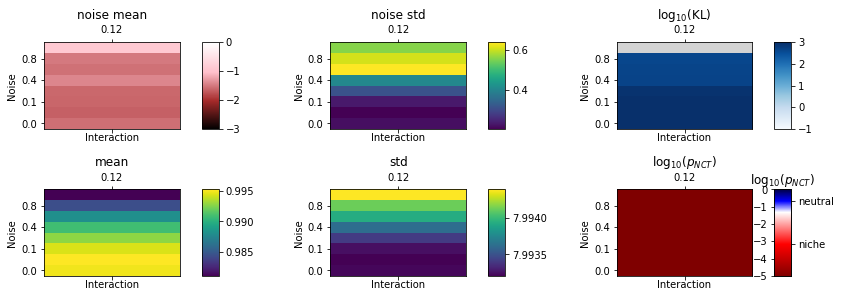

In [29]:
PlotOverview('%s_unif-300.csv')

plt.show()

Results for dt = 0.01, tskip = 49 and T = 500 -> sampling 0.5, NCT 500

The mean abundance of the species is 0.01.


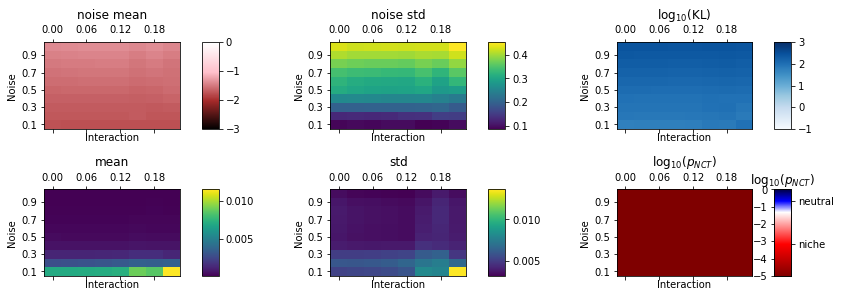

The mean abundance of the species is 0.1.


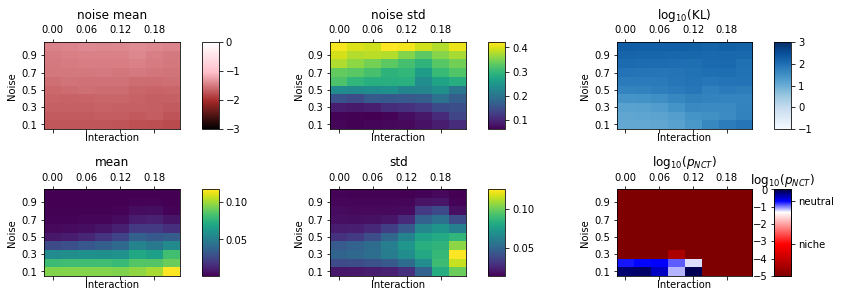

The mean abundance of the species is 1.


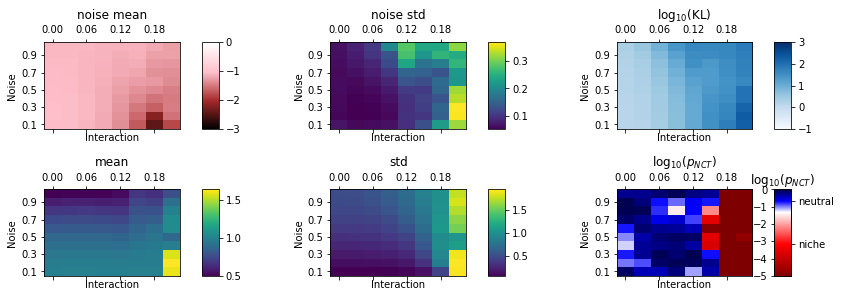

The mean abundance of the species is 10.


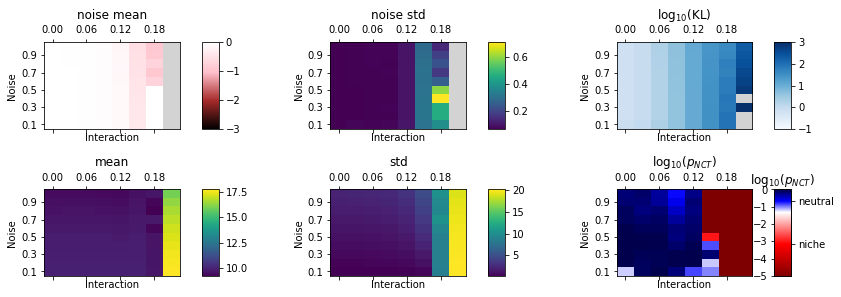

The mean abundance of the species is 100.


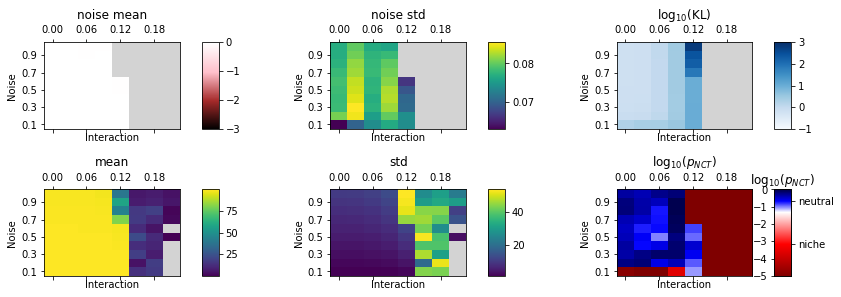

In [14]:
for ma in ['0.01', '0.1', '1', '10', '100']: 
    
    print("The mean abundance of the species is %s." % ma)
    
    folder = ''
    plot_overview('KullbackLeibler/Langevinlinear/Langevinlinear-' + ma + '-%s-%d.csv', range(8))
    
    plt.show()

The mean abundance of the species is 31.6.


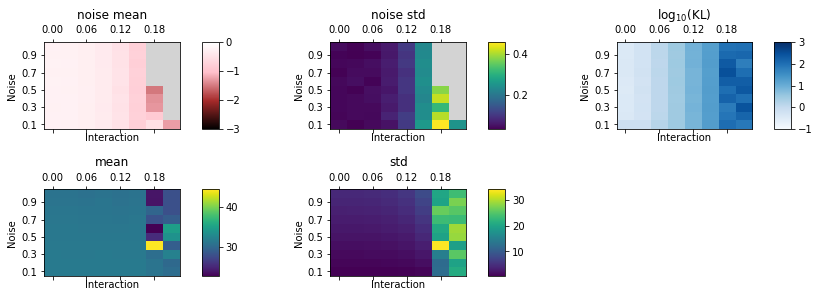

In [37]:
for ma in ['31.6']: #'10', '17.8', '31.6', '56.2', '100']: #['0.01', '0.1', '1', '10', '20', '50', '100']:
    
    print("The mean abundance of the species is %s." % ma)
    
    plot_overview('KullbackLeibler/Langevinlinear/Langevinlinear-' + ma + '-%s-%d.csv', [1]) #range(5))
    
    plt.show()

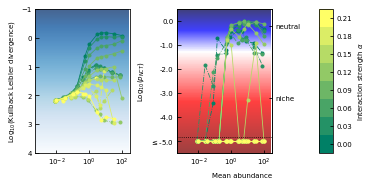

In [3]:
#sizes = ['0.01', '0.0316', '0.1', '0.178', '0.316', '0.562', '1', 
#         '1.78', '3.16', '5.62', '10', '17.8', '31.6', '56.2', '100']
#sizes_f = [float(size) for size in sizes]

sizes = ['0.01', '0.0316', '0.1', '0.178', '0.562', '1', '3.16', '5.62', '10', '31.6','100']
sizes_f = np.array([float(size) for size in sizes])

fig = plt.figure(figsize = (textwidth,2.5))

gs = gridspec.GridSpec(1, 3, width_ratios=[7,7,1], wspace=0.7, bottom=0.15, right=0.85, left=0.1, top=0.95)

ax_KL = fig.add_subplot(gs[0])
ax_NCT = fig.add_subplot(gs[1])
ax_clb = fig.add_subplot(gs[2])

norm = matplotlib.colors.Normalize(vmin=0, vmax=0.21, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='summer')

for selfint in [0.8, 1]:
    for i, ma in enumerate(sizes):
        if selfint == 0.5:
            file = 'KullbackLeibler/Langlin_selfint0.5/KL_' + ma + '.csv'

            data = pd.read_csv(file, index_col=0)
            d = data.values; d[np.isinf(d)] = np.nan;

            KL = np.nanmean(d, axis=1)
            KLe = np.nanstd(d, axis=1)

            file = 'KullbackLeibler/Langlin_selfint0.5/NCT_' + ma + '.csv'

            data = pd.read_csv(file, index_col=0)

            d = data.values; d[np.isinf(d)] = np.nan;

            NCT = np.nanmedian(d, axis=1)
            NCTe = np.nanstd(d, axis=1)
        elif selfint == 0.8:
            file = 'KullbackLeibler/Langlin_selfint0.8/KL_' + ma + '.csv'

            data = pd.read_csv(file, index_col=0)
            d = data.values; d[np.isinf(d)] = np.nan;

            KL = np.nanmean(d, axis=1)
            KLe = np.nanstd(d, axis=1)

            file = 'KullbackLeibler/Langlin_selfint0.5/NCT_' + ma + '.csv'

            data = pd.read_csv(file, index_col=0)

            d = data.values; d[np.isinf(d)] = np.nan;

            NCT = np.nanmedian(d, axis=1)
            NCTe = np.nanstd(d, axis=1)
        elif selfint == 1:
            file = 'KullbackLeibler/Langevinlinear/Langevinlinear-' + ma + '-KL-%d.csv'

            num = [0] #np.arange(10)

            data = pd.DataFrame( np.nanmean(
                    [pd.read_csv(file % iii, index_col=0).values 
                         for iii in num], axis=0),
                              columns = pd.read_csv(file % num[0], index_col=0).columns,
                            index = pd.read_csv(file % num[0], index_col=0).index)

            d = data.values; d[np.isinf(d)] = np.nan;

            KL = np.nanmean(d, axis=1)
            KLe = np.nanstd(d, axis=1)

            file = 'KullbackLeibler/Langevinlinear/Langevinlinear-' + ma + '-NCT-%d.csv'

            data = pd.DataFrame( np.nanmean(
                    [pd.read_csv(file % iii, index_col=0).values 
                         for iii in num], axis=0),
                              columns = pd.read_csv(file % num[0], index_col=0).columns,
                            index = pd.read_csv(file % num[0], index_col=0).index)

            d = data.values; d[np.isinf(d)] = np.nan;

            NCT = np.nanmedian(d, axis=1)
            NCTe = np.nanstd(d, axis=1)

        if i == 0:
            interaction = data.index.astype('float')
            KLs = np.copy(KL)
            KLes = np.copy(KLe)
            NCTs = np.copy(NCT)
            NCTes = np.copy(NCTe)
        else:
            KLs = np.vstack((KLs, KL))
            KLes = np.vstack((KLes, KLe))
            NCTs = np.vstack((NCTs, NCT))
            NCTes = np.vstack((NCTes, NCTe))

    minNCT = 1e-5
    NCTs[NCTs < minNCT] = minNCT

    colors = np.array([(mapper.to_rgba(v)) for v in interaction])
    for i in range(len(interaction)):
        if selfint == 0.5:
            ls = ':o'
        elif selfint == 1:
            ls = '-o'
        elif selfint == 0.8:
            ls = '-.o'
        
        ax_KL.plot(selfint*sizes_f, np.log10(KLs[:,i]), ls, c=colors[i])
        ax_NCT.plot(selfint*sizes_f, np.log10(NCTs[:,i]), ls, c=colors[i])
        scat = ax_NCT.scatter(selfint*sizes_f, np.log10(NCTs[:,i]), c= np.full_like(sizes_f, interaction[i]), s = 0.01, cmap='summer', vmin=0, vmax= 0.21)

vmin = -1; vmax = 4
x = np.linspace(vmin, vmax, 500).reshape([500,1])
ax_KL.imshow(x, cmap='Blues', vmin=vmin, vmax=vmax, extent=(5e-4, 3e2, vmin, vmax), aspect='auto', alpha=0.75)

ax_KL.set_xscale('log')
ax_KL.set_ylabel(r'Log$_{10}$(Kullback Leibler divergence)')
#ax_KL.set_xlabel('Mean abundance')
ax_KL.set_ylim([vmax, vmin])
bds = np.arange(-0.015,0.23,0.03)

vmin = -5.5; vmax = 0.5 # vmax higher than zero otherwis points glued to upper boundary
x = np.linspace(vmin, vmax, 500).reshape([500,1])
norm = PiecewiseNormalize([vmin, vmax  - (np.log10(0.05) - vmin), vmax], [0, 0.5, 1])
ax_NCT.imshow(x, norm = norm, cmap='seismic', vmin = vmin, vmax= vmax, extent=(5e-4, 3e2, vmin, vmax), aspect='auto', alpha=0.75)

#plt.yscale('log')
ax_NCT.set_xscale('log')
ax_NCT.set_ylabel(r'Log$_{10}(p_{NCT})$')
ax_NCT.set_xlabel(r'Mean abundance', ha='right', x=1)
ax_NCT.set_ylim([vmin, vmax])
bds = np.arange(-0.015,0.23,0.03)

ticks = np.arange(np.log10(minNCT), vmax,1)
ticklabels = [str(tick) if tick > np.log10(minNCT) else r'$\leq$%.1f' % np.log10(minNCT) for tick in ticks]
ax_NCT.set_yticks(ticks)
ax_NCT.set_yticklabels(ticklabels)
ax_NCT.axhline(y=np.log10(1.5*minNCT), linestyle=':', c='k')

ax_NCT2 = ax_NCT.twinx()
ax_NCT.yaxis.set_ticks_position('left')
ax_NCT2.yaxis.set_ticks_position('right')
vmax = 0 # centralize the neutral niche labels
ax_NCT2.yaxis.set_ticks([1+(vmin + np.log10(0.05))/(vmax - vmin)/2,
                        1+(vmax + np.log10(0.05))/(vmax - vmin)/2])
ax_NCT2.set_ylim([0,1])
ax_NCT2.yaxis.set_ticklabels(['niche','neutral'])

fig.colorbar(scat, boundaries=bds, ticks=interaction, label=r'Interaction strength $\alpha$', ax=ax_NCT, cax=ax_clb)

#plt.savefig('figures/neutral_niche_gLV.pdf')
plt.savefig('figures_elife/supplemental/neutral_niche_gLV2.pdf')
plt.show()

200.620101213 105.989419603 94.6306816095
105.989419603 105.989419603 0.0
109.945589951 105.989419603 3.95617034709
104.683358011 105.989419603 1.30606159201
205.989517129 105.989419603 100.000097526
200.620101213 105.989419603 94.6306816095
101.608226155 105.989419603 4.38119344798
125.916822744

/Users/wkits/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/Users/wkits/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


 105.989419603 19.9274031405


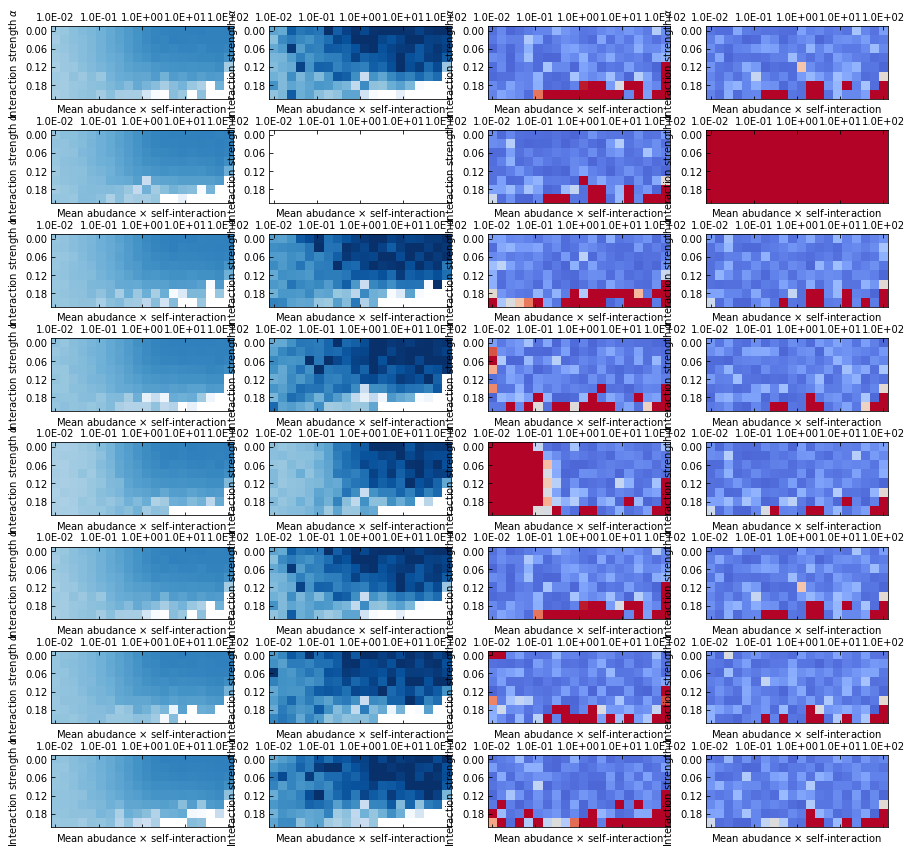

In [64]:
def plot_neutralities(df, ax, colors='KL'):
    if colors == 'KL':
        vmin = -1; vmax = 4
        cmap='Blues_r'
        norm = None
    elif colors == 'NCT':
        vmin = -5.5; vmax = 0.5
        norm = PiecewiseNormalize([vmin, vmax  - (np.log10(0.05) - vmin), vmax], [0, 0.5, 1])
        cmap='coolwarm_r'
    
    ax.matshow(np.log10(df.T), norm=norm, cmap=cmap, vmin=vmin, vmax=vmax)

    #plt.colorbar()

    xmin = min(df.index.astype(float)); xmax = max(df.index.astype(float));
    N = 5
    ax.set_xticks(np.linspace(0, int(df.shape[0]-1), N))
    ax.set_xticklabels(['%.1E' % i for i in 
                        np.logspace(np.log10(xmin), np.log10(xmax), N)])

    skiplabel = int(df.shape[1] / 6)
    ax.set_yticks(range(0, df.shape[1], (skiplabel+1)))
    ax.set_yticklabels(['%.2f' % i for i in df.columns.astype(float)][::(skiplabel+1)])
    ax.set_xlabel(r'Mean abudance $\times$ self-interaction')
    ax.set_ylabel(r'Interaction strength $\alpha$')

fig = plt.figure(figsize=(15,15))

for i, f in enumerate(['test/KL_fig19_0.01.csv', 
                        'test/KL_fig19_0.1.csv', 
                       'test/KL_fig19_0.1b.csv', 
                       'test/KL_fig19_0.1c.csv', 
                       'test/KL_fig19_0.5.csv', 
                       'test/KL_fig19_0.01.csv',
                      'test/KL_fig19_si_0.1.csv',
                      'test/KL_fig19_si_10.csv',]):
    ax = fig.add_subplot(8,4,(4*i)+1)
    df = pd.read_csv(f, index_col=0)
    plot_neutralities(df, ax, colors='KL')
    ax = fig.add_subplot(8,4,(4*i)+2)
    df = np.abs(pd.read_csv(f, index_col=0) - pd.read_csv('test/KL_fig19_0.1.csv', index_col=0))
    plot_neutralities(df, ax, colors='KL')
    print(pd.read_csv(f, index_col=0).values[0,-1],
          pd.read_csv('test/KL_fig19_0.1.csv', index_col=0).values[0,-1],
         df.values[0,-1])
for i, f in enumerate(['test/NCT_fig19_0.01.csv', 
                        'test/NCT_fig19_0.1.csv', 
                       'test/NCT_fig19_0.1b.csv', 
                       'test/NCT_fig19_0.1c.csv', 
                       'test/NCT_fig19_0.5.csv', 
                       'test/NCT_fig19_0.01.csv',
                      'test/NCT_fig19_si_0.1.csv',
                      'test/NCT_fig19_si_10.csv',]):
    ax = fig.add_subplot(8,4,(4*i)+3)
    df = pd.read_csv(f, index_col=0)
    plot_neutralities(df, ax, colors='NCT')
    ax = fig.add_subplot(8,4,(4*i)+4)
    df = np.abs(pd.read_csv(f, index_col=0) - pd.read_csv('test/NCT_fig19_0.1.csv', index_col=0))
    plot_neutralities(df, ax, colors='NCT')
plt.show()


Results for dt = 0.01, tskip = 49 and T = 100 (like the simulations for the other parts of the paper) -> sampling 0.5 

CVT test: number of timepoints: 200, number of species: 50
KL 3.79660403007 NCT 0.22812006951
[1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01
 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01
 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01
 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01
 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01
 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01 1.20E+01
 1.20E+01 1.20E+01]


/Users/wkits/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


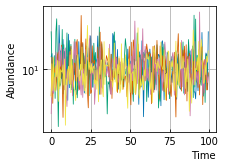

In [18]:
# check validity of neutrality figure by looking at timeseries

ma = 10
S = 50
    
alpha = 0  
omega = 0.1
    
params = {}

steadystate = np.repeat(float(ma), S).reshape([S,1])  
            
params['initial_condition'] = steadystate * np.random.normal(1,0.1, steadystate.shape)
            
# interaction
if alpha == 0:
    intmat = np.zeros([S,S])
else:
    intmat = np.random.normal(0, sigma, [S,S])
np.fill_diagonal(intmat, -1.2)
params['interaction_matrix'] = intmat

# no immigration
params['immigration_rate'] = np.zeros([S, 1])

# growthrates determined by the steady state
params['growth_rate'] = - intmat.dot(steadystate).reshape([S,1])

params['noise_linear'] = omega

params['initial_condition'] = Timeseries(params, model = MODEL.GLV, 
                                         noise_implementation = NOISE.LANGEVIN_LINEAR,
                     dt=0.01, T=10, tskip = 49).endpoint

ts = Timeseries(params, model = MODEL.GLV, noise_implementation = NOISE.LANGEVIN_LINEAR,
                     dt=0.01, T=100, tskip = 49).timeseries

PlotTimeseriesComparison([ts], composition=['ts'])

if ts.isnull().values.sum().sum() == 0 and np.all(ts.drop('time', axis=1).sum(axis=1) > 0): # no NAN values and not all species die
    KL = KullbackLeibler_neutrality(ts)
    norm_ts = ts.values[:, 1:]
    norm_ts /= norm_ts.sum(axis=1, keepdims=True)
    NCT = neutral_covariance_test(norm_ts, ntests=500, method = 'Kolmogorov', seed=56)
else:
    KL = np.nan; NCT = np.nan

print("KL", KL, "NCT", NCT)
print(params['growth_rate'].flatten())

In [ ]:
plt.figure()

sigmas = [0,0.09,0.21] # mean interaction strength
omegas = [0.01, 0.4, 1.0] # noise
Ss = ['0.01', '1', '100']
spec = ['species_1', 'species_22', 'species_47']

for S in Ss:
    for i, sigma in enumerate(sigmas):
        print(sigma)
        for j, omega in enumerate(omegas):
            f = "KullbackLeibler/Langevinlinear/LV-%s-%.2f-%.2f.csv" % (S, sigma, omega)

            ts = pd.read_csv(f, index_col=0, na_values='NAN')
            
            ns = noise_slope(ts)['slope_linear']
                        
            plt.scatter(np.mean(ts[spec], axis=0), ns.loc[spec])

plt.xscale('log')
plt.show()

In [90]:
S = 50

initcond = 50*np.ones([S,1])

intmat = np.random.normal(0,0.05,[S,S])
np.fill_diagonal(intmat, -1)

# no immigration
mu = 0*np.ones([S, 1])

# growthrates determined by the steady state
K = - intmat.dot(initcond).reshape([S,1])

initcond = np.random.normal(1,0.1,initcond.shape)*initcond

var = intmat, mu, K, initcond

ts = run_timeseries_noise(var, noise=0.2, f=0, model = MODEL.GLV,
                noise_implementation = NOISE.LANGEVIN_LINEAR,
                 dt=0.01, T=500, tskip = 49)
                


In [94]:
print(neutral_covariance_test(normalize(ts.T), ntests=500, method='Kolmogorov'))


0.29558444838


# Scale invariance

Can timeseries with sqrt noise be rescaled?

In [ ]:
Nspecies = 1

params = {}

steadystate = 1

# interaction
omega = np.zeros([N,N]); np.fill_diagonal(omega, -1);

params['interaction_matrix'] = omega

# no immigration
params['immigration_rate'] = np.zeros([N, 1])

# different growthrates determined by the steady state
params['growthrate'] = - (omega).dot(steadystate)

params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

params['noise_linear'] = 0
params['noise_sqrt'] = 0.2

ts = run_timeseries_noise(params, noise_implementation = NOISE.LANGEVIN_LINEAR_SQRT, 
                    dt = 0.01, tskip=19, T=50.0, seed=int(time.time()))

fig = plt.figure(figsize=(40/2.54,7/2.54), tight_layout=True)

plot_timeseries_comparison([ts], composition=['ts'], vertical=False, fig=fig)

